In [8]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)



In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
fname = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR9Yhcch85ziIad4CyZQqLtYijHgsuENLfyC0YAXlajVbSC7U7s3CUUsfG-OYIKOjTI9DdKZH1xMs3a/pub?output=csv'
df= pd.read_csv(fname,index_col=0)
df



,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [11]:
# ### Train Test Split
## Make x and y variables
drop_feats = ["Name","Ticket","Cabin"]
y = df['Survived'].copy()
X = df.drop(columns=['Survived',*drop_feats]).copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
# ### Preprocessing + ColumnTransformer
## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)





,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_MISSING,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
355,3.0,30.314472,0.0,0.0,7.225,1.0,1.0,0.0,0.0,0.0
519,2.0,36.000000,1.0,0.0,26.000,0.0,0.0,0.0,0.0,1.0
814,3.0,6.000000,4.0,2.0,31.275,0.0,0.0,0.0,0.0,1.0


In [12]:
## fit random forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_df,y_train)



RandomForestClassifier()

- Next, evaluate your model's performance on the training and test data and then apply Shap!

In [13]:
def evaluate_classification(model, X_train,y_train,X_test,y_test,
                            normalize='true',cmap='Blues', figsize=(10,5)):
    header="\tCLASSIFICATION REPORT"
    dashes='--'*40
    print(f"{dashes}\n{header}\n{dashes}")
    ## training data
    print('[i] Training Data:')
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_train,y_train,
                                                  normalize=normalize,
                                                   cmap=cmap,ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_train,y_train,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    
    fig.tight_layout()
    plt.show()
     
    print(dashes)
    ## test data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,
                                                  normalize=normalize,
                                                   cmap=cmap, ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()



--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       419
           1       0.98      0.97      0.98       249

    accuracy                           0.98       668
   macro avg       0.98      0.98      0.98       668
weighted avg       0.98      0.98      0.98       668



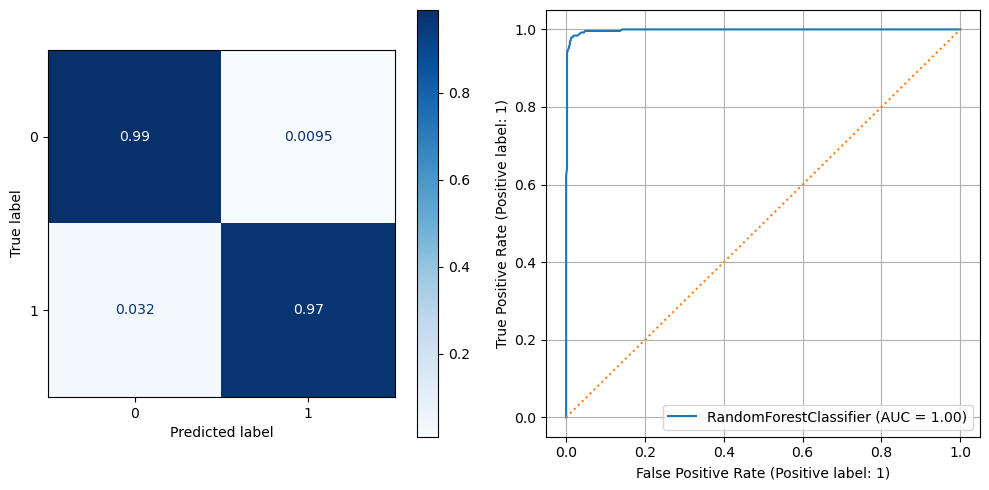

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       130
           1       0.81      0.83      0.82        93

    accuracy                           0.85       223
   macro avg       0.84      0.84      0.84       223
weighted avg       0.85      0.85      0.85       223



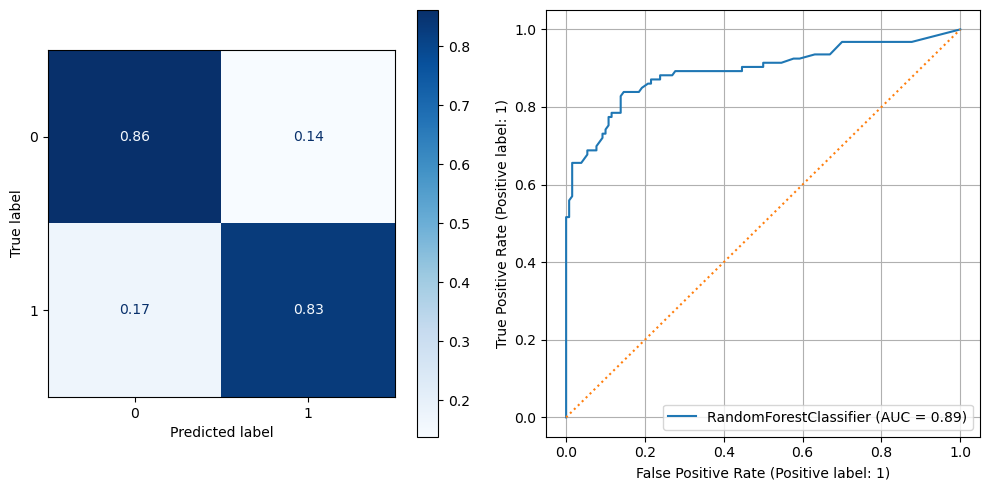

In [14]:
evaluate_classification(rf_clf,X_train_df,y_train, X_test_df,y_test)

In [16]:
# Import shap and initialize javascript:
import shap
shap.initjs()


In [17]:
len(X_train_df)


668

In [18]:
X_shap = shap.sample(X_train_df,nsamples=668,random_state=321)
X_shap.head()


,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_MISSING,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
255,3.0,41.00,0.0,2.0,20.2125,0.0,0.0,0.0,0.0,1.0
470,3.0,0.75,2.0,1.0,19.2583,0.0,1.0,0.0,0.0,0.0
813,2.0,35.00,0.0,0.0,10.5000,1.0,0.0,0.0,0.0,1.0
298,1.0,2.00,1.0,2.0,151.5500,0.0,0.0,0.0,0.0,1.0
82,3.0,29.00,0.0,0.0,9.5000,1.0,0.0,0.0,0.0,1.0


In [19]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap 


PassengerId
255    0
470    1
813    0
298    0
82     1
      ..
713    1
810    1
800    0
125    0
539    0
Name: Survived, Length: 668, dtype: int64

In [20]:
explainer = shap.Explainer(rf_clf)
explainer


In [24]:
## Getting the shap values
shap_values = explainer(X_shap,y_shap)
type(shap_values)


shap._explanation.Explanation

In [25]:
X_shap.shape

(668, 10)

In [27]:
shap_values.shape

(668, 10, 2)

In [28]:
# slicing for failing values 
shap_vals_1 = shap_values[:,:,1]
shap_vals_1.shape


(668, 10)

In [29]:
pd.DataFrame(shap_vals_1.values, columns = X_shap.columns)


,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_MISSING,Embarked_Q,Embarked_S
0,-0.168035,-0.159738,0.003340,-0.058102,-0.015112,0.226113,-0.022760,-0.000030,0.003882,-0.013549
1,-0.059054,0.146707,0.006760,0.035235,0.045049,0.155350,0.065912,-0.000007,0.004436,0.027621
2,-0.011291,-0.053156,0.002777,-0.002902,-0.060616,-0.204859,-0.015015,-0.000013,0.000976,-0.017891
3,0.005400,-0.007223,-0.028793,-0.085615,-0.102053,0.059976,-0.033867,-0.000046,0.001355,-0.021125
4,0.031605,0.178997,0.025382,0.006637,0.120355,-0.062993,-0.000073,-0.000012,0.001587,0.006524
...,...,...,...,...,...,...,...,...,...,...
663,0.195737,0.065699,0.083388,0.005865,0.133065,-0.151504,-0.026397,-0.000103,0.002975,-0.010717
664,0.177857,0.022162,0.016097,0.008814,0.098516,0.308105,-0.008820,-0.000035,0.000667,-0.005354
665,-0.156420,-0.056336,-0.021374,-0.016294,-0.096504,0.212799,-0.023487,-0.000010,-0.009963,-0.034403
666,0.076350,-0.110629,-0.022820,-0.007775,0.036335,-0.224615,-0.029326,-0.000301,0.001920,-0.021130


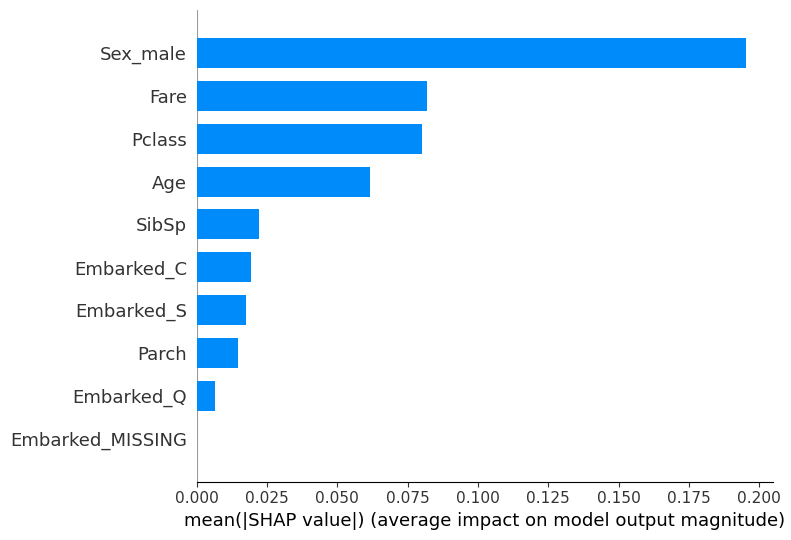

In [30]:
shap.summary_plot(shap_vals_1,features= X_shap, plot_type='bar')



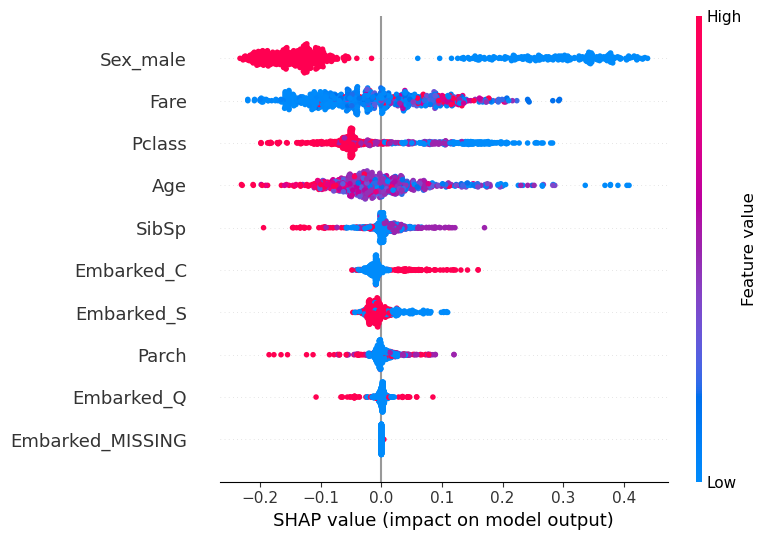

In [31]:
shap.summary_plot(shap_vals_1,X_shap)


- If the red is on the right (positive), higher values of this feature increase the chance the prediction will be fail.
- If the red is on the left (negative), higher values of this feature decrease the chances the prediction will be fail.


- Because red values are on the right (positive), we can see that the greater the number of ------, the more likely the model would predict the passenger would survive.
